In [17]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import time
import LSE_net
from torch import optim
import importlib

In [18]:
seed=4;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)

Running on:  cpu


num_drones = 5	num_facilities = 5	dim = 2
Data Loaded.


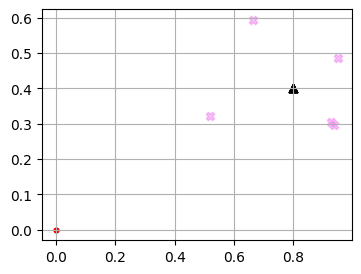

In [19]:
# UAV FLPO MetaData
num_drones = 5
n_drone_clusters = 5
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 5
dim_ = 2
print(f'num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}')

# Assign start location to each drone
drone_cnt = 0
for i in range(n_drone_clusters):
    if i == n_drone_clusters-1:
        n_drones = int(num_drones - drone_cnt)
    else:
        n_drones = int(drone_cluster_split[i] * (num_drones+1))
        drone_cnt += n_drones

    drone_cluster_mean = torch.rand(1, dim_).repeat(n_drones,1).unsqueeze(1).to(device)
    drone_cluster_std = ((0.01 - 0.05) * torch.rand(1,dim_) + 0.05).repeat(n_drones,1).unsqueeze(1).to(device)
    drone_cluster_START_locs = torch.normal(mean=drone_cluster_mean, std=drone_cluster_std)
    if i == 0:
        START_locs = drone_cluster_START_locs
    else:
        START_locs = torch.cat((START_locs, drone_cluster_START_locs), axis=0)

START_locs.shape

# Assign destination location to each drone
END_locs = torch.zeros((num_drones, 1, dim_), requires_grad=False, device=device) #torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)

# Create the data tensor
F_base = (torch.mean(START_locs, dim=0).repeat(num_facilities, 1) + torch.normal(mean=torch.zeros(num_facilities,1), std=0.001*torch.ones(num_facilities,1))).unsqueeze(0).requires_grad_().to(device)
# print(F_base.shape)
F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)
print("Data Loaded.")

# plot the data
def plot_UAV_FLPO(drone_START, drone_END, Facilities, figuresize=(6,5)):
    start_locs = drone_START.squeeze(1).cpu().numpy()
    end_locs = drone_END.squeeze(1).cpu().numpy()
    f_locs = Facilities.squeeze(0).detach().cpu().numpy()

    plt.figure(figsize=figuresize)
    plt.scatter(start_locs[:,0], start_locs[:,1], color='violet', marker='X', alpha=0.5)
    plt.scatter(end_locs[:,0], end_locs[:,1], color='red', marker='.')
    plt.scatter(f_locs[:,0], f_locs[:,1], color='black', marker='^')
    plt.grid()
    plt.show()

plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))

### Load the VRP NET Module

In [20]:
hidden_dim = 32
num_layers_enc = 1
num_layers_dec = 1
num_heads = 8
torch.cuda.empty_cache()
vrp_net = VRPNet_L(dim_, hidden_dim, device, num_layers_enc, num_layers_dec, num_heads)
if torch.cuda.is_available():
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=True))
else:
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=False, map_location=torch.device('cpu')))
vrp_net.eval()

# for param in vrp_net.parameters():
#     param.requires_grad = False
print('VRP NET loaded on: ',vrp_net.device)
print(summary(vrp_net))

VRP NET loaded on:  cpu
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,560
│    └─MultiheadAttention: 2-1                                         197,376
│    │    └─NonDynamicallyQuantizableLinear: 3-1                       65,792
│    └─Linear: 2-2                                                     768
│    └─Linear: 2-3                                                     8,224
│    └─LayerNorm: 2-4                                                  512
│    └─Dropout: 2-5                                                    --
│    └─ReLU: 2-6                                                       --
├─Decoder: 1-2                                                         --
│    └─TransformerDecoder: 2-7                                         --
│    │    └─ModuleList: 3-2                                       

### Load the LSE net module

In [21]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_1__17_6_31.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
# lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


### Some functions for free energy approximation

In [22]:
def logSumExp(D_tensor, beta):
    # with torch.no_grad():
    # print(D_tensor)
    D_min = torch.min(D_tensor, axis=1, keepdims=True)
    F = -1/beta * torch.log(torch.sum(torch.exp(-beta*(D_tensor - D_min.values)), axis=1, keepdims=True)) + 1/beta * torch.log(torch.tensor([D_tensor.shape[1]])) + D_min.values
    return F

def area_approx_F(D_min, D_max_range, beta, printCalculations=False):
    min_beta_D_arr = beta * D_min
    x_max = beta * D_max_range - min_beta_D_arr
    F_est = -1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max))) + D_min
    
    if printCalculations:
        print(f'min_beta_D_arr:{min_beta_D_arr}')
        print(f'x_max:{x_max}')
        print(f'inside_log:{1/x_max * (1 - torch.exp(-x_max))}')
        print(f'log:{torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        print(f'-1/beta_log:\n{-1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        
    return F_est

### Optimization loop for a single beta

In [23]:
# Shortest path and its gradient wrt facility locations
def VRPNet_pass(vrp_net, F_locs, returnGrad=False):
    data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)

    s = time.time()
    with torch.no_grad():
        # forward pass: no activations are saved for grad
        _, actions = vrp_net(data, mod='eval_greedy')
    e = time.time()
    actions.detach()
    D_min_drones = utils.route_cost(data, actions).view(-1,1)
    if returnGrad:
        gradient = torch.autograd.grad(outputs=D_min_drones, inputs=F_locs,
                                grad_outputs=torch.ones_like(D_min_drones),
                                create_graph=True)
        dDmin_dFlocs = gradient[0]
    else:
        dDmin_dFlocs = None

    return D_min_drones, dDmin_dFlocs, e-s

# Free energy as a function of shortest path, and its gradients
def LSENet_pass(lse_net, D_min_drones, D_max_range, beta, beta_min, returnGrad=False):
    Fmin_est = area_approx_F(D_min_drones, D_max_range=D_max_range, beta=beta_min, printCalculations=False)
    In_lse = torch.cat((
        Fmin_est.to(device),
        D_min_drones,
        (torch.ones(D_min_drones.shape)*torch.log(torch.tensor([beta]))/torch.log(torch.tensor([10.0]))).to(device)
    ), axis=1)
    FreeEnergy = lse_net(In_lse)
    if returnGrad:
        gradient = torch.autograd.grad(outputs=FreeEnergy, inputs=In_lse,
                                grad_outputs=torch.ones_like(FreeEnergy),
                                create_graph=True)
        # dFreeE_dDmin = gradient[0].view(num_drones,1,1)
        dFreeE_dDmin = gradient[0][:,1].view(-1,1).view(num_drones,1,1)
    else:
        dFreeE_dDmin = None

    return FreeEnergy, dFreeE_dDmin

# gradient descent step
def gradient_descent_step(Y, dY, eta):
    Y = Y - eta * dY
    return Y

# optimize using gradient descent at given beta
def GD_at_beta0(F_base0, num_drones, vrp_net, lse_net, iters, optim_stepsize, beta_min, beta, D_max_range, allowPrint=False):

    F_base = F_base0
    assert(F_base.requires_grad == True)

    for i in range(iters):
        
        F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
        
        # free energy and gradients using VRP_net and LSE_net
        D_min_drones, dDmin_dFlocs, _ = VRPNet_pass(vrp_net, F_locs, returnGrad=True)
        freeEnergy_drones, dFreeE_dDmin = LSENet_pass(
            lse_net, D_min_drones, D_max_range=D_max_range, 
            beta=beta, beta_min=beta_min, returnGrad=True)

        torch.cuda.empty_cache()

        # total gradient using chain rule and backpropagation
        total_gradient = dDmin_dFlocs * dFreeE_dDmin
        G = torch.mean(total_gradient, axis=0)

        # optimizer step
        F_base = gradient_descent_step(F_base, G, eta)

        # print data
        if allowPrint:
            print(f'iter: {i}\tFreeE: {torch.mean(freeEnergy_drones):.4e}\tdDmin: {torch.max(torch.abs(dDmin_dFlocs)):.4e}\tdFreeE: {torch.max(torch.abs(dFreeE_dDmin)):.4e}\t G:{torch.max(torch.abs(G)):.4e}')

    return F_base, freeEnergy_drones, G

# optimize using gradient descent at given beta
def GD_at_beta1(F_base0, num_drones, vrp_net, lse_net, iters, optim_stepsize, beta_min, beta, D_max_range, allowPrint=False):

    F_base = F_base0
    assert(F_base.requires_grad == True)

    for i in range(iters):
        
        F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
        
        # free energy and gradients using VRP_net and LSE_net
        D_min_drones, _, _ = VRPNet_pass(vrp_net, F_locs, returnGrad=False)
        freeEnergy_drones, _ = LSENet_pass(
            lse_net, D_min_drones, D_max_range=D_max_range, 
            beta=beta, beta_min=beta_min, returnGrad=False)
        freeEnergy = torch.mean(freeEnergy_drones)

        torch.cuda.empty_cache()

        # total gradient using chain rule and backpropagation
        total_gradient = torch.autograd.grad(outputs=freeEnergy, inputs=F_base,
                                grad_outputs=torch.ones_like(freeEnergy),
                                create_graph=True)
        G = total_gradient[0]

        # optimizer step
        F_base = gradient_descent_step(F_base, G, eta)

        # print data
        if allowPrint:
            print(f'iter: {i}\tFreeE: {freeEnergy:.4e}\tG:{torch.max(torch.abs(G)):.4e}')

    return F_base, freeEnergy_drones, G


def Adam_at_beta(F_base0, num_drones, vrp_net, lse_net, iters, optim_stepsize, beta_min, beta, D_max_range, allowPrint=False):

    F_base = F_base0
    assert(F_base.requires_grad == True)
    optimizer = optim.Adam([F_base], lr=optim_stepsize)

    for i in range(iters):
        F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
        
        # free energy and gradients using VRP_net and LSE_net
        D_min_drones, _, _ = VRPNet_pass(vrp_net, F_locs)
        freeEnergy_drones, _ = LSENet_pass(
            lse_net, D_min_drones, D_max_range=D_max_range, beta=beta, beta_min=beta_min)
        FreeEnergy = torch.mean(freeEnergy_drones)

        torch.cuda.empty_cache()

        # compute gradient of free energy wrt F_base using backpropagation
        optimizer.zero_grad()
        FreeEnergy.backward()
        G = F_base.grad

        # optimizer step
        optimizer.step()

        # print data
        if allowPrint:
            print(f'iter: {i}\tFreeE: {FreeEnergy:.4e}')
    
    return F_base, FreeEnergy, G

# perform annealing
def anneal(F_base0, num_drones, vrp_net, lse_net, iters, step, beta_min, beta_max, beta_grow, D_max_range, optimizer_name, allowPrint):

    beta = beta_min
    F_base = F_base0
    b_arr = []
    F_arr = []

    while beta <= beta_max:
        # optimize using gradient descent iterations

        if optimizer_name == 'gradient_descent0':
            F_base, FreeEnergy, G = GD_at_beta0(
                F_base, num_drones, vrp_net, lse_net, optim_iters, 
                optim_step, beta_min, beta, D_max_range=D_max_range, allowPrint=False)
        
        elif optimizer_name == 'gradient_descent1':
            F_base, FreeEnergy, G = GD_at_beta1(
                F_base, num_drones, vrp_net, lse_net, optim_iters, 
                optim_step, beta_min, beta, D_max_range=D_max_range, allowPrint=False)

        elif optimizer_name == 'adam':
            F_base, FreeEnergy, G = Adam_at_beta(
                F_base, num_drones, vrp_net, lse_net, optim_iters, 
                optim_step, beta_min, beta, D_max_range=D_max_range, allowPrint=False)

        # store data
        b_arr.append(beta)
        F_arr.append(torch.mean(FreeEnergy).detach().item())
        # print data
        if allowPrint:
            print(f'beta: {beta:.4e}\tFreeE: {torch.mean(FreeEnergy):.4f}\tGrad: {torch.abs(torch.max(G)):.4e}')
        # update beta
        beta = beta * beta_grow

    return F_base, b_arr, F_arr

    

In [24]:
iters = 500
eta = 0.1
b_min = 1e-3
beta = 1e-3

F_base, FreeEnergy, G = GD_at_beta0(
    F_base, num_drones, vrp_net, lse_net, iters, 
    eta, b_min, beta, D_max_range=2.0, allowPrint=True)


iter: 0	FreeE: 1.4239e+00	dDmin: 1.6012e+00	dFreeE: 1.2243e-03	 G:1.1733e-03
iter: 1	FreeE: 1.4224e+00	dDmin: 1.6012e+00	dFreeE: 1.2243e-03	 G:1.1727e-03
iter: 2	FreeE: 1.4103e+00	dDmin: 1.6011e+00	dFreeE: 1.2243e-03	 G:1.1722e-03
iter: 3	FreeE: 1.4190e+00	dDmin: 1.6011e+00	dFreeE: 1.2243e-03	 G:1.1712e-03
iter: 4	FreeE: 1.4180e+00	dDmin: 1.6011e+00	dFreeE: 1.2243e-03	 G:1.3072e-03
iter: 5	FreeE: 1.4253e+00	dDmin: 1.6011e+00	dFreeE: 1.2243e-03	 G:1.1718e-03
iter: 6	FreeE: 1.4234e+00	dDmin: 1.6008e+00	dFreeE: 1.2243e-03	 G:1.1712e-03
iter: 7	FreeE: 1.4199e+00	dDmin: 1.6006e+00	dFreeE: 1.2243e-03	 G:1.2372e-03
iter: 8	FreeE: 1.4252e+00	dDmin: 1.6004e+00	dFreeE: 1.2243e-03	 G:1.1710e-03
iter: 9	FreeE: 1.4244e+00	dDmin: 1.6001e+00	dFreeE: 1.2243e-03	 G:1.2368e-03
iter: 10	FreeE: 1.4167e+00	dDmin: 1.5999e+00	dFreeE: 1.2243e-03	 G:1.1707e-03
iter: 11	FreeE: 1.4179e+00	dDmin: 1.5997e+00	dFreeE: 1.2243e-03	 G:1.2364e-03
iter: 12	FreeE: 1.4180e+00	dDmin: 1.5994e+00	dFreeE: 1.2243e-03	 G:1.1704e

In [9]:
# iters = 500
# eta = 0.001
# b_min = 1e-3
# beta = 1e-3

# F_base, FreeEnergy, G = Adam_at_beta(
#     F_base, num_drones, vrp_net, lse_net, iters, 
#     eta, b_min, beta, D_max_range=2.0, allowPrint=True)


In [10]:
# iters = 1000
# eta = 0.01
# b_min = 1e-3
# beta = 1e-3

# F_base, FreeEnergy, G = GD_at_beta1(
#     F_base, num_drones, vrp_net, lse_net, iters, 
#     eta, b_min, beta, D_max_range=2.0, allowPrint=True)


iter: 0	FreeE: 1.4239e+00	G:4.7502e-01
iter: 1	FreeE: 1.4252e+00	G:3.2930e-01
iter: 2	FreeE: 1.4294e+00	G:4.8600e-01
iter: 3	FreeE: 1.4120e+00	G:4.6651e-01
iter: 4	FreeE: 1.4155e+00	G:3.9232e-01
iter: 5	FreeE: 1.4025e+00	G:5.3372e-01
iter: 6	FreeE: 1.4002e+00	G:5.2794e-01
iter: 7	FreeE: 1.4087e+00	G:5.2760e-01
iter: 8	FreeE: 1.4002e+00	G:5.1171e-01
iter: 9	FreeE: 1.3960e+00	G:5.0477e-01
iter: 10	FreeE: 1.3857e+00	G:4.8752e-01
iter: 11	FreeE: 1.3843e+00	G:4.7338e-01
iter: 12	FreeE: 1.3768e+00	G:4.6450e-01
iter: 13	FreeE: 1.3801e+00	G:4.6469e-01
iter: 14	FreeE: 1.3785e+00	G:4.5596e-01
iter: 15	FreeE: 1.3803e+00	G:4.4635e-01
iter: 16	FreeE: 1.3810e+00	G:4.3770e-01
iter: 17	FreeE: 1.3797e+00	G:4.3373e-01
iter: 18	FreeE: 1.3789e+00	G:4.2595e-01
iter: 19	FreeE: 1.3725e+00	G:4.2226e-01
iter: 20	FreeE: 1.3745e+00	G:4.1108e-01
iter: 21	FreeE: 1.3629e+00	G:4.0074e-01
iter: 22	FreeE: 1.3528e+00	G:3.8689e-01
iter: 23	FreeE: 1.3624e+00	G:3.8451e-01
iter: 24	FreeE: 1.3499e+00	G:3.7501e-01
iter: 25	F

In [25]:
F_base

tensor([[[0.7889, 0.3893],
         [0.7897, 0.3969],
         [0.7885, 0.3976],
         [0.7898, 0.3966],
         [0.7432, 0.3779]]], grad_fn=<SubBackward0>)

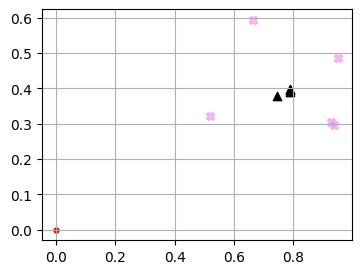

In [26]:
plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))

### Optimization loop for increasing beta

In [43]:
optim_iters = 200
optim_step = 0.1 # 0.1 for gd0, use < 0.01 for the other two optimizers
beta_min = 1e-3
beta_max = 1e5
beta_grow = 3
beta = 1e-3

F_base, b_arr, F_arr = anneal(
    F_base, num_drones, vrp_net, lse_net, optim_iters, optim_step, 
    beta_min, beta_max, beta_grow, D_max_range=2.0, 
    optimizer_name='gradient_descent0', allowPrint=True)


beta: 1.0000e-03	FreeE: 1.3718	Grad: 1.0314e-03
beta: 3.0000e-03	FreeE: 1.3534	Grad: 9.4309e-04
beta: 9.0000e-03	FreeE: 1.3310	Grad: 9.4154e-04
beta: 2.7000e-02	FreeE: 1.1542	Grad: 2.6768e-03
beta: 8.1000e-02	FreeE: 1.0838	Grad: 5.1806e-03
beta: 2.4300e-01	FreeE: 1.0567	Grad: 6.4388e-03
beta: 7.2900e-01	FreeE: 0.9776	Grad: 4.3463e-06
beta: 2.1870e+00	FreeE: 0.8144	Grad: 2.9206e-07
beta: 6.5610e+00	FreeE: 0.5622	Grad: 2.9206e-07
beta: 1.9683e+01	FreeE: 0.3717	Grad: 2.7120e-07
beta: 5.9049e+01	FreeE: 0.2432	Grad: 4.4195e-03
beta: 1.7715e+02	FreeE: 0.2160	Grad: 2.0672e-02
beta: 5.3144e+02	FreeE: 0.1882	Grad: 4.6555e-05
beta: 1.5943e+03	FreeE: 0.1873	Grad: 3.0335e-08
beta: 4.7830e+03	FreeE: 0.1864	Grad: 3.0335e-08
beta: 1.4349e+04	FreeE: 0.1855	Grad: 3.0335e-08
beta: 4.3047e+04	FreeE: 0.1846	Grad: 3.0335e-08


In [44]:
F_base

tensor([[[0.5649, 0.2896],
         [0.6738, 0.3355],
         [0.2933, 0.1494],
         [0.4400, 0.2241],
         [0.1467, 0.0747]]], grad_fn=<SubBackward0>)

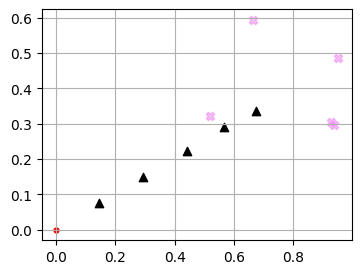

In [45]:
plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))

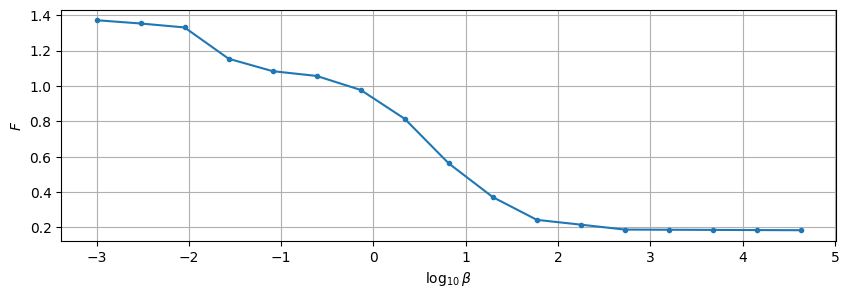

In [51]:
# plot free energy evolution
plt.figure(figsize=(10,3))
plt.plot(np.log(b_arr)/np.log(10), F_arr, marker='.')
plt.ylabel(rf'$F$')
plt.xlabel(rf'$\log_{{10}}\beta$')
plt.grid()
plt.show()